In [1]:
import sys

sys.path.append("../")  # up one level

import os
import shutil

import gcsfs
import geopandas as gpd
import pandas as pd
from calitp_data_analysis.sql import to_snakecase
from calitp_data_analysis.tables import tbls
from segment_speed_utils.project_vars import PUBLIC_GCS
from siuba import _, collect, count, filter, select, show_query
from update_vars import GCS_FILE_PATH, NTD_MODES, NTD_TOS

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/ntd/"

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Work plan

## Need List of all annual reporters
- Full, Reduced, Rural reporters all submit an annual Report to NTD

## Need to assign rural and reduced annual reporters to RTPAs
- Full reporters are already mapped to RTPAs via the monthly report
- but reduced and rurap reporters need to be mapped to RTPAs

### How to traverse operators to RTPA?
- find all the operators in a GTFS schedule. 
- do any of the rural operators appear in a schedule?
    - if so, then what is the RTPA of that schedule!!!!!
    - ntd > operator > schedule > RTPA 

## Read in `dim_annual_service_agencies` to get metrics
but need to RTPA info to this data

In [2]:
# dim_annual_service_agenices is the annual report module.
# included uza, VRM, VRH, UPT
# report years include 2022-2023

ntd_service = (
    tbls.mart_ntd.dim_annual_service_agencies()
    >> filter(_.state == "CA")
    >> select(
        "report_year",
        "ntd_id",
        "agency",
        "reporter_type",
        "organization_type",
        "city",
        "state",
        "primary_uza_name",
        "actual_vehicles_passenger_car_revenue_hours",
        "actual_vehicles_passenger_car_revenue_miles",
        "unlinked_passenger_trips_upt",
    )
    >> collect()
)
ntd_service.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   report_year                                  421 non-null    int64  
 1   ntd_id                                       421 non-null    object 
 2   agency                                       421 non-null    object 
 3   reporter_type                                421 non-null    object 
 4   organization_type                            421 non-null    object 
 5   city                                         418 non-null    object 
 6   state                                        421 non-null    object 
 7   primary_uza_name                             328 non-null    object 
 8   actual_vehicles_passenger_car_revenue_hours  421 non-null    float64
 9   actual_vehicles_passenger_car_revenue_miles  421 non-null    float64
 10  un

### update `ntd_service` to:
- 90227 City of Moorpark > city = Moorpark
- 90253 City of Bell Gardens > city = Bell Gardens
- 90259 City of Cerritos > city = Cerritos
- 90286 City of Monterey Park > city = Monterey Park

In [3]:
#Moorpark Update
ntd_service.loc[ntd_service["ntd_id"]=="90227","city"] = "Moorpark"

# Bell Gardens Update
ntd_service.loc[ntd_service["ntd_id"]=="90253","city"] = "Bell Gardens"

# Cerritos Update
ntd_service.loc[ntd_service["ntd_id"]=="90259","city"] = "Cerritos"

# Monterey Park Update
ntd_service.loc[ntd_service["ntd_id"]=="90286","city"] = "Monterey Park"

### Does `ntd_id-to-rtap crosswalk` include rural/reduced reporter info?

In [4]:
# reading in NTD ID crosswalk from GCS
ntd_rtpa_crosswalk = pd.read_csv(
    f"{GCS_FILE_PATH}ntd_id_rtpa_crosswalk.csv", dtype={"ntd_id": "str"}
).rename(columns={"NTD ID": "ntd_id"})

ntd_rtpa_crosswalk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ntd_id          122 non-null    object
 1   Legacy NTD ID   111 non-null    object
 2   Agency          122 non-null    object
 3   UZA Name        121 non-null    object
 4   RTPA_open_data  122 non-null    object
 5   RTPA            122 non-null    object
dtypes: object(6)
memory usage: 5.8+ KB


In [5]:
# are all agencies in the ntd_service in the crosswalk? NO
check = ntd_service.merge(ntd_rtpa_crosswalk, on="ntd_id", how="left", indicator=True)

# the rural reporters are not in the ntd_rtpa_crosswalk
check[check["_merge"] == "left_only"]["reporter_type"].value_counts()

Reduced Reporter    132
Rural Reporter       89
Name: reporter_type, dtype: int64

In [6]:
# crosswalk[["UZA Name", "RTPA"]].sort_values(by="UZA Name")

Some UZA Names can go to multiple RTPAs
- some agencies in the Sacramento UZA go to Sac and Placer RTPA
- some agencies in LA UZA got to Metro or OCTA


In [7]:
# just rural/reduced reporters
rural_reduced_reporters = ntd_service[
    ntd_service["reporter_type"] != "Full Reporter"
].sort_values(by="primary_uza_name")

In [8]:
# rural_reduced_reporters.to_csv("rural_reduced_reporters.csv")

## Get all operators from RTPA using function from Tiffany

via [slack thread](https://cal-itp.slack.com/archives/C02H6JUSS9L/p1729102048291249)

initial work done in `rtpa_operator_explore.ipynb`

- rip `create_gtfs_dataset_key_to_organization_crosswalk` function from `gtfs_funnel/crosswalk_gtfs_dataset_key_to_organization.py`
- rip any date from GCS (latest is 2025-01-15) `calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk`
- find the corresponding `gtfs_key-to-org crosswalk` by date (2025-01-15) via `calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk`

can use these 2 dataframes to go from `schedule_gtfs_dataset_key (operator)` > `ntd_id`

A single schedule feed can have multiple operators. This is how you identify 

In [9]:
# need this to run `create_gtfs_dataset_key_to_organzaition_crosswalk`
from segment_speed_utils import helpers
from shared_utils.schedule_rt_utils import (
    sample_gtfs_dataset_key_to_organization_crosswalk,
)

In [10]:
def create_gtfs_dataset_key_to_organization_crosswalk(
    analysis_date: str,
) -> pd.DataFrame:
    """
    For every operator that appears in schedule data,
    create a crosswalk that links to organization_source_record_id.
    For all our downstream outputs, at various aggregations,
    we need to attach these over and over again.
    """
    df = helpers.import_scheduled_trips(
        analysis_date, columns=["gtfs_dataset_key", "name"], get_pandas=True
    ).rename(columns={"schedule_gtfs_dataset_key": "gtfs_dataset_key"})
    # rename columns because we must use simply gtfs_dataset_key in schedule_rt_utils function

    # Get base64_url, organization_source_record_id and organization_name
    crosswalk = sample_gtfs_dataset_key_to_organization_crosswalk(
        df,
        analysis_date,
        quartet_data="schedule",
        dim_gtfs_dataset_cols=["key", "source_record_id", "base64_url"],
        dim_organization_cols=[
            "source_record_id",
            "name",
            "itp_id",
            "caltrans_district",
            "ntd_id_2022",
        ],
    )

    df_with_org = pd.merge(
        df.rename(columns={"gtfs_dataset_key": "schedule_gtfs_dataset_key"}),
        crosswalk,
        on="schedule_gtfs_dataset_key",
        how="inner",
    )

    return df_with_org

In [11]:
# get gtfs to org df,
# same date as used below
gtfs_to_org = create_gtfs_dataset_key_to_organization_crosswalk(
    "2025-01-15"  # 216 total rows
    # "2024-10-14" #209 rows
    # "2024-08-14" #206 rows
    # "2024-03-13" #193 rows
).rename(columns={"name": "schedule_name"})


gtfs_to_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 215
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   schedule_gtfs_dataset_key      216 non-null    object 
 1   schedule_name                  216 non-null    object 
 2   schedule_source_record_id      216 non-null    object 
 3   base64_url                     216 non-null    object 
 4   organization_source_record_id  216 non-null    object 
 5   organization_name              216 non-null    object 
 6   itp_id                         204 non-null    float64
 7   caltrans_district_x            214 non-null    object 
 8   ntd_id_2022                    172 non-null    object 
 9   caltrans_district_y            216 non-null    object 
dtypes: float64(1), object(9)
memory usage: 18.6+ KB


In [12]:
# initialize gtfs rosswalk
gtfs_key_orgs = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk/gtfs_key_organization_2025-01-15.parquet"
)
gtfs_key_orgs.columns # not sure i cant use these columns

Index(['schedule_gtfs_dataset_key', 'name', 'schedule_source_record_id',
       'base64_url', 'organization_source_record_id', 'organization_name',
       'caltrans_district', 'counties_served', 'hq_city', 'hq_county',
       'is_public_entity', 'is_publicly_operating', 'funding_sources',
       'on_demand_vehicles_at_max_service', 'vehicles_at_max_service',
       'number_of_state_counties', 'primary_uza_name', 'density',
       'number_of_counties_with_service', 'state_admin_funds_expended',
       'service_area_sq_miles', 'population', 'service_area_pop',
       'subrecipient_type', 'primary_uza_code', 'reporter_type',
       'organization_type', 'voms_pt', 'voms_do', 'year'],
      dtype='object')

## Merge `ntd_service` data to `gtfs_to_orgs` list
Results should be the ntd_service data with the GTFS schedule name 

In [13]:
keep_cols = [
    "schedule_gtfs_dataset_key",
    "schedule_name",
    "organization_name",
    "ntd_id_2022",
]

ntd_metrics_to_sched = ntd_service.merge(
    gtfs_to_org[keep_cols],
    right_on="ntd_id_2022",
    left_on="ntd_id",
    how="left",
    indicator=True,
)
display(ntd_metrics_to_sched.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 0 to 454
Data columns (total 16 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  455 non-null    int64   
 1   ntd_id                                       455 non-null    object  
 2   agency                                       455 non-null    object  
 3   reporter_type                                455 non-null    object  
 4   organization_type                            455 non-null    object  
 5   city                                         455 non-null    object  
 6   state                                        455 non-null    object  
 7   primary_uza_name                             356 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  455 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  455 non-null    floa

None

In [14]:
ntd_metrics_to_sched["_merge"].value_counts()
# so there are some left-only rows, meaning some operators did not match to schedule
# on date 2025-01-15: 257 both, 88 left_only = 88 reporters did not match to a shcedule

both          326
left_only     129
right_only      0
Name: _merge, dtype: int64

In [15]:
# what are the reporter types for these left_only operators?
ntd_metrics_to_sched[ntd_metrics_to_sched["_merge"] == "left_only"][
    "reporter_type"
].value_counts()  # 65 reduced, 23 full reporters

# also checked "both" and got mix of full, reduced and rural
# may need to check a different crosswalk data

Reduced Reporter    74
Rural Reporter      32
Full Reporter       23
Name: reporter_type, dtype: int64

In [16]:
# looking into the cities of the left_only merges
ntd_metrics_to_sched[ntd_metrics_to_sched["_merge"] == "left_only"][
    ["agency", "reporter_type", "city"]
].value_counts()

agency                                                                          reporter_type     city            
Los Angeles County                                                              Reduced Reporter  Alhambra            9
Access Services                                                                 Full Reporter     El Monte            2
City of Malibu                                                                  Reduced Reporter  Malibu              2
Paratransit, Inc.                                                               Full Reporter     Sacramento          2
City of Covina                                                                  Reduced Reporter  Covina              2
City of Davis, dba: Davis Community Transit                                     Reduced Reporter  Davis               2
Easy Lift Transportation                                                        Reduced Reporter  Goleta              2
City of Huntington Park                      

In [17]:
# if i sort by city, can i match copy the RTPA of the good rows to the left_only rows?
ntd_metrics_to_sched[
    ["agency", "city", "schedule_gtfs_dataset_key", "schedule_name", "_merge"]
].sort_values(by=["city", "agency"], ascending=True).head(10)

,agency,city,schedule_gtfs_dataset_key,schedule_name,_merge
334,City of Agoura Hills,Agoura Hills,NaN,NaN,left_only
335,City of Agoura Hills,Agoura Hills,NaN,NaN,left_only
336,"City of Alhambra, dba: Alhambra Community Transit",Alhambra,9471fbb88956076b211cc4a8df1a536c,Alhambra Schedule,both
337,"City of Alhambra, dba: Alhambra Community Tran...",Alhambra,9471fbb88956076b211cc4a8df1a536c,Alhambra Schedule,both
381,Los Angeles County,Alhambra,NaN,NaN,left_only
382,Los Angeles County,Alhambra,2606479845d2cf0077fac54ff25a3a69,LADPW Schedule,both
385,Los Angeles County,Alhambra,NaN,NaN,left_only
386,Los Angeles County,Alhambra,NaN,NaN,left_only
389,Los Angeles County,Alhambra,NaN,NaN,left_only
391,Los Angeles County,Alhambra,NaN,NaN,left_only


## merge `ntd_metrics_to_sched` df to `ntd_to_rtpa` crosswalk
Result should be a df of ntd service reports with GTFS schedule, then RTPA name merged in

In [18]:
metrics_sched_rtpa = ntd_metrics_to_sched.drop(columns="_merge", axis=1).merge(
    ntd_rtpa_crosswalk, on="ntd_id", how="left", indicator=True
)

metrics_sched_rtpa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 0 to 456
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  457 non-null    int64   
 1   ntd_id                                       457 non-null    object  
 2   agency                                       457 non-null    object  
 3   reporter_type                                457 non-null    object  
 4   organization_type                            457 non-null    object  
 5   city                                         457 non-null    object  
 6   state                                        457 non-null    object  
 7   primary_uza_name                             358 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  457 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  457 non-null    floa

In [19]:
metrics_sched_rtpa["_merge"].value_counts()
# on date 2025-01-15: 227 both, 120 left_only = 120 reporters did not match to a RTPA
# ideally want every row to match

left_only     229
both          228
right_only      0
Name: _merge, dtype: int64

In [20]:
# get DF of agencies > reporter type > city > schedule name > rtpa
# if 2 reporters share the same City, then are they part of the same schedule? or part of the same RTPA?

metrics_sched_rtpa[
    [
        "report_year",
        "ntd_id",
        "agency",
        "reporter_type",
        "city",
        "schedule_name",
        "RTPA",
    ]
].sort_values(by=["city", "RTPA"], ascending=True)

# examples to pull: Camarillo, Riverside, 

,report_year,ntd_id,agency,reporter_type,city,schedule_name,RTPA
336,2023,90246,City of Agoura Hills,Reduced Reporter,Agoura Hills,NaN,NaN
337,2022,90246,City of Agoura Hills,Reduced Reporter,Agoura Hills,NaN,NaN
338,2023,90247,"City of Alhambra, dba: Alhambra Community Transit",Reduced Reporter,Alhambra,Alhambra Schedule,NaN
339,2022,90247,"City of Alhambra, dba: Alhambra Community Tran...",Reduced Reporter,Alhambra,Alhambra Schedule,NaN
380,2022,90269,Los Angeles County Dept. of Public Works - Ath...,Reduced Reporter,Alhambra,NaN,NaN
381,2023,90269,"Los Angeles County, dba: LA County Public Works",Reduced Reporter,Alhambra,NaN,NaN
382,2022,90270,Los Angeles County Department of Public Works ...,Reduced Reporter,Alhambra,NaN,NaN
383,2023,90270,Los Angeles County,Reduced Reporter,Alhambra,NaN,NaN
384,2023,90271,Los Angeles County,Reduced Reporter,Alhambra,LADPW Schedule,NaN
385,2022,90271,Los Angeles County Department of Public Works ...,Reduced Reporter,Alhambra,LADPW Schedule,NaN


## try merging GDF of city in `ntd_service` to RTPA bounaries.
- To match agency cities to RTPAs. (this method doesnt need schedule info)

Census Designated Places (CDPs) 2010 - California map
- https://data.sacog.org/datasets/SACOG::census-designated-places-cdps-2010-california/about

~~California Incorporated Cities (dont think this included census derived places or unincorporated areas.)~~
~~- https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::california-incorporated-cities-1/explore~~

RTPA map opend data
- https://www.lab.data.ca.gov/dataset/regional-transportation-planning-agencies

In [21]:
import geopandas as gpd

In [22]:
rtpa_url = "https://cecgis-caenergy.opendata.arcgis.com/api/download/v1/items/3a83743378be4e7f84c8230889c01dea/geojson?layers=0"
rtpa_map = gpd.read_file(rtpa_url)[["RTPA","LABEL_RTPA","geometry"]]#.set_crs("ESRI:102600", allow_override=True)
print(rtpa_map.crs)
rtpa_map = rtpa_map.to_crs("ESRI:102600") # for sjoin later
print(rtpa_map.crs)

EPSG:4326
ESRI:102600


In [23]:
# California Census Designated Places (2010), includes cities and CDPs

cdp_url="https://services6.arcgis.com/YBp5dUuxCMd8W1EI/arcgis/rest/services/California_Census_Designated_Places_2010/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
keep_cdp_col=["FID","NAME10","NAMELSAD10","geometry"]
cdp_map= gpd.read_file(cdp_url)[keep_cdp_col].rename(columns={"NAME10":"cdp_name","NAMELSAD10":"name_lsad"})#.set_crs("ESRI:102600", allow_override=True)


### test getting centroid of CDPs

In [24]:
cdp_map["centroid"] = cdp_map["geometry"].to_crs("ESRI:102600").centroid # CRS used to create centoid. is not presistent
cdp_points= cdp_map.set_geometry("centroid", drop=True)

display(
cdp_map.info(),
cdp_points.info(), #geometry column here is point geometry 
cdp_map.crs, # default CRS
cdp_points.crs, # new CRS
cdp_points.head(),
)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   FID        1523 non-null   int64   
 1   cdp_name   1523 non-null   object  
 2   name_lsad  1523 non-null   object  
 3   geometry   1523 non-null   geometry
 4   centroid   1523 non-null   geometry
dtypes: geometry(2), int64(1), object(2)
memory usage: 59.6+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1523 entries, 0 to 1522
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   FID        1523 non-null   int64   
 1   cdp_name   1523 non-null   object  
 2   name_lsad  1523 non-null   object  
 3   geometry   1523 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 47.7+ KB


None

None

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Projected CRS: ESRI:102600>
Name: NAD_1983_California_Teale_Albers_FtUS
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: NAD_1983_California_Teale_Albers_FtUS
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

,FID,cdp_name,name_lsad,geometry
0,1,Tehama,Tehama city,POINT (-595373.083 9861237.699)
1,2,Red Bluff,Red Bluff city,POINT (-626074.577 9917237.059)
2,3,Corning,Corning city,POINT (-611576.889 9827491.545)
3,4,Williams,Williams city,POINT (-605443.950 9543097.586)
4,5,Colusa,Colusa city,POINT (-568847.549 9562798.386)


In [25]:
cdp_points.explore() # some point are in the ocean (SF and a lot of bay area places)!! 

## sjoin ~~`cities_map`~~ `cdp_map` gdf and `rtpa_map` gdf to attach RTPA name to cities

In [26]:
cdp_points.crs == rtpa_map.crs
#both are ESRI:102600

True

In [27]:
city_to_rtpa = gpd.sjoin(
    cdp_points, # includes cities and CDPs.
    rtpa_map,
    how="left",
    #how="inner",
    predicate="intersects", 
    #predicate="within",
)
# left, intersects = 1523 rows, 1521 CDPs matched,2 CDPs did not match to an RTPA (Avalon and City of San Francisco)
# inner, intersects = 1521 rows,1521 CDPs matched 
# left, within = 1523 rows, 1521 CDPs matched,2 CDPs did not match to an RTPA
# inner, within = 1521 rows,1521 CDPs matched

display(
    len(cdp_points),
    len(rtpa_map),
    city_to_rtpa[city_to_rtpa["RTPA"].isna()], # checking for unmerged cdps
    city_to_rtpa.info(),
    city_to_rtpa.crs

)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1523 entries, 0 to 1522
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   FID          1523 non-null   int64   
 1   cdp_name     1523 non-null   object  
 2   name_lsad    1523 non-null   object  
 3   geometry     1523 non-null   geometry
 4   index_right  1521 non-null   float64 
 5   RTPA         1521 non-null   object  
 6   LABEL_RTPA   1521 non-null   object  
dtypes: float64(1), geometry(1), int64(1), object(4)
memory usage: 95.2+ KB


1523

43

,FID,cdp_name,name_lsad,geometry,index_right,RTPA,LABEL_RTPA
862,863,Avalon,Avalon city,POINT (510003.406 7421706.792),NaN,NaN,NaN
889,890,San Francisco,San Francisco city,POINT (-777550.185 9040909.841),NaN,NaN,NaN


None

<Projected CRS: ESRI:102600>
Name: NAD_1983_California_Teale_Albers_FtUS
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: NAD_1983_California_Teale_Albers_FtUS
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [28]:
# fix unmerged cdp rtpa rows 

#Avalon fix
city_to_rtpa.loc[city_to_rtpa["cdp_name"]=="Avalon",("RTPA","LABEL_RTPA")] = ("Southern California Association of Governments", "SCAG")

# San Francisco Fix
city_to_rtpa.loc[city_to_rtpa["cdp_name"]=="San Francisco",("RTPA","LABEL_RTPA")] = ("Metropolitan Transportation Commission", "MTC")

#check fix
city_to_rtpa[city_to_rtpa["cdp_name"].isin(["Avalon","San Francisco"])]


,FID,cdp_name,name_lsad,geometry,index_right,RTPA,LABEL_RTPA
862,863,Avalon,Avalon city,POINT (510003.406 7421706.792),NaN,Southern California Association of Governments,SCAG
889,890,San Francisco,San Francisco city,POINT (-777550.185 9040909.841),NaN,Metropolitan Transportation Commission,MTC


In [29]:
# Why do these cdp occur twice?
check_names= [
"Burbank",
"Paradise",
"Strawberry",
"Live Oak",
"Rolling Hills",
"Spring Valley",
"Cold Springs",
"Greenfield",
"Green Valley",
"Mountain View",
"El Cerrito",
"Franklin",
"San Miguel",
"Las Flores",
"Bayview",
"El Sobrante"
]

city_to_rtpa[city_to_rtpa["cdp_name"].isin(check_names)].sort_values(by="cdp_name").head()

# Some places in CA have the same name, but are in different locations! Burbank in NorCal and Burbank in SoCal!
# after reviewing all these, theres should not be an conflicts since all the RTPs are in different locations/not conflicting

,FID,cdp_name,name_lsad,geometry,index_right,RTPA,LABEL_RTPA
1384,1385,Bayview,Bayview CDP,POINT (-1157476.285 10150984.394),10.0,Humboldt County Association of Governments,Humboldt CAG
1041,1042,Bayview,Bayview CDP,POINT (-667585.382 9127613.797),20.0,Metropolitan Transportation Commission,MTC
240,241,Burbank,Burbank CDP,POINT (-560442.842 8875457.036),20.0,Metropolitan Transportation Commission,MTC
852,853,Burbank,Burbank city,POINT (506926.263 7732433.446),35.0,Southern California Association of Governments,SCAG
1327,1328,Cold Springs,Cold Springs CDP,POINT (-249560.830 9390874.336),7.0,El Dorado County Transportation Commission,El Dorado CTC


Need to manualy update Avalon on the dataset

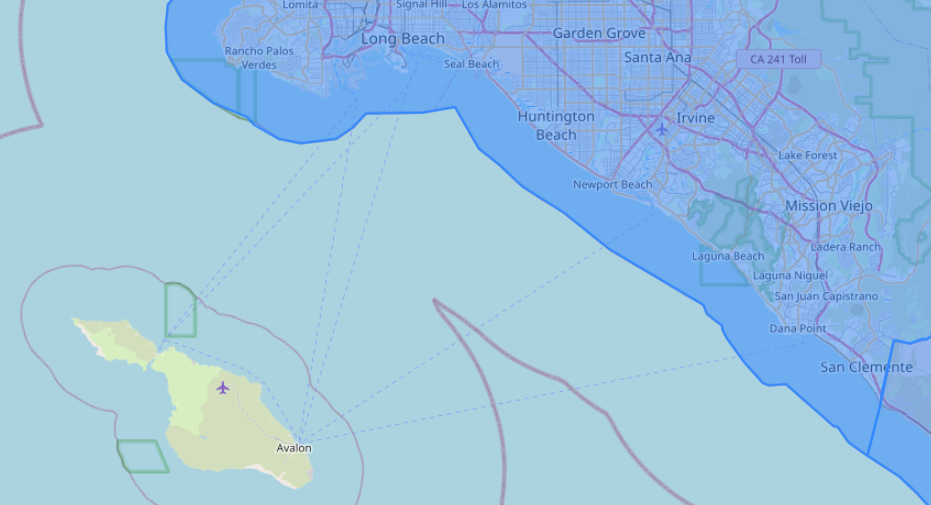

## merge `ntd_service` to `city_to_rtpa`
join on City. attach RTPA name to ntd annual data

In [30]:
ntd_data_to_rtpa = ntd_service.merge(
    city_to_rtpa[["cdp_name","RTPA"]],
    left_on=("city"),
    right_on=("cdp_name"),
    how="left", # with left join, got some unmerged rows. aka reporters that dont appear in the city_to_rtpa list (CDP?). and fan out 1:m rows due to some dupe cdp names
    indicator=True
)
ntd_data_to_rtpa.info() #424 rows 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 423
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  424 non-null    int64   
 1   ntd_id                                       424 non-null    object  
 2   agency                                       424 non-null    object  
 3   reporter_type                                424 non-null    object  
 4   organization_type                            424 non-null    object  
 5   city                                         424 non-null    object  
 6   state                                        424 non-null    object  
 7   primary_uza_name                             331 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  424 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  424 non-null    floa

## manual updates to `ntd_data_to_rtpa`


### Rows with NaN RTPAs

In [32]:
ntd_data_to_rtpa[ntd_data_to_rtpa["RTPA"].isna()][["report_year","agency","city","cdp_name","RTPA"]] # 9 rows didnt get an RTPA

,report_year,agency,city,cdp_name,RTPA
240,2023,"City of McFarland, dba: McFarland City Transit...",Mcfarland,NaN,NaN
241,2022,City of McFarland,Mcfarland,NaN,NaN
382,2022,Palos Verdes Peninsula Transit Authority,Palos Verdes Peninsula,NaN,NaN
401,2022,County of Ventura,Ventura,NaN,NaN
402,2023,County of Ventura,Ventura,NaN,NaN
417,2023,Chemehuevi Indian Tribe,Havasu Lake,NaN,NaN
418,2022,Chemehuevi Indian Tribe,Havasu Lake,NaN,NaN
421,2022,North Fork Rancheria of Mono Indians of Califo...,North Fork,NaN,NaN
422,2023,North Fork Rancheria of Mono Indians of Califo...,North Fork,NaN,NaN


### Unmerged agencies to RTPAs
- some agencies did not merge to an rtpa
- manually add the RTPA name to these rows

In [33]:
# checking unmerged CDP names existed in the cities lsit
city_check_list = list(ntd_data_to_rtpa[ntd_data_to_rtpa["_merge"]=="left_only"]["city"].unique())

pattern = "|".join(city_check_list)

display(
    city_check_list,
    city_to_rtpa[city_to_rtpa["cdp_name"].str.contains(pattern, case=False)],
    cdp_points[cdp_points["cdp_name"].str.contains(pattern, case=False)],
    ntd_data_to_rtpa[ntd_data_to_rtpa["city"].str.contains(pattern, case=False)]
)



['Mcfarland', 'Palos Verdes Peninsula', 'Ventura', 'Havasu Lake', 'North Fork']

,FID,cdp_name,name_lsad,geometry,index_right,RTPA,LABEL_RTPA
91,92,McFarland,McFarland city,POINT (225014.644 8271632.704),12.0,Kern Council of Governments,KCOG
600,601,San Buenaventura (Ventura),San Buenaventura (Ventura) city,POINT (226239.897 7758058.837),35.0,Southern California Association of Governments,SCAG


,FID,cdp_name,name_lsad,geometry
91,92,McFarland,McFarland city,POINT (225014.644 8271632.704)
600,601,San Buenaventura (Ventura),San Buenaventura (Ventura) city,POINT (226239.897 7758058.837)


,report_year,ntd_id,agency,reporter_type,organization_type,city,state,primary_uza_name,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles,unlinked_passenger_trips_upt,cdp_name,RTPA,_merge
240,2023,91110,"City of McFarland, dba: McFarland City Transit...",Rural Reporter,"City, County or Local Government Unit or Depar...",Mcfarland,CA,None,1095.0,6518.0,3433.0,NaN,NaN,left_only
241,2022,91110,City of McFarland,Rural Reporter,"City, County or Local Government Unit or Depar...",Mcfarland,CA,None,615.0,3817.0,2756.0,NaN,NaN,left_only
382,2022,90287,Palos Verdes Peninsula Transit Authority,Reduced Reporter,Independent Public Agency or Authority of Tran...,Palos Verdes Peninsula,CA,"Los Angeles--Long Beach--Anaheim, CA",16411.0,242914.0,122042.0,NaN,NaN,left_only
401,2022,90298,County of Ventura,Reduced Reporter,"City, County or Local Government Unit or Depar...",Ventura,CA,"Thousand Oaks, CA",2582.0,27909.0,32349.0,NaN,NaN,left_only
402,2023,90298,County of Ventura,Reduced Reporter,"City, County or Local Government Unit or Depar...",Ventura,CA,"Thousand Oaks, CA",2604.0,29364.0,36267.0,NaN,NaN,left_only
417,2023,99316,Chemehuevi Indian Tribe,Reduced Reporter,Tribe,Havasu Lake,CA,California Non-UZA,6500.0,40000.0,200000.0,NaN,NaN,left_only
418,2022,99316,Chemehuevi Indian Tribe,Reduced Reporter,Tribe,Havasu Lake,CA,"Lake Havasu City, AZ",7363.0,41000.0,179723.0,NaN,NaN,left_only
421,2022,99364,North Fork Rancheria of Mono Indians of Califo...,Reduced Reporter,Tribe,North Fork,CA,California Non-UZA,135.0,6752.0,484.0,NaN,NaN,left_only
422,2023,99364,North Fork Rancheria of Mono Indians of Califo...,Reduced Reporter,Tribe,North Fork,CA,California Non-UZA,129.0,6130.0,602.0,NaN,NaN,left_only


In [34]:
ntd_data_to_rtpa.columns

Index(['report_year', 'ntd_id', 'agency', 'reporter_type', 'organization_type',
       'city', 'state', 'primary_uza_name',
       'actual_vehicles_passenger_car_revenue_hours',
       'actual_vehicles_passenger_car_revenue_miles',
       'unlinked_passenger_trips_upt', 'cdp_name', 'RTPA', '_merge'],
      dtype='object')

In [39]:
update_dict={
    "Mcfarland": ("Mcfarland","Kern Council of Governments"),
    "Ventura":("Ventura","Southern California Association of Governments"),
    "Palos Verdes Peninsula":("Rolling Hills","Southern California Association of Governments"),# to match other entries for this agency
    "Havasu Lake":("Havasu Lake","Southern California Association of Governments"), # aka Lake Havasu. shares zip code with Needles. so update to SCAG
    "North Fork":("North Fork","Madera County Transportation Commission") #in Madera County, update to 
}

#make loop using update_dict:
for k,v in update_dict.items():
    ntd_data_to_rtpa.loc[ntd_data_to_rtpa["city"]==k,("cdp_name","RTPA")] = v
    


In [40]:
#check for NaN RTPAs again
ntd_data_to_rtpa[ntd_data_to_rtpa["RTPA"].isna()][["report_year","agency","city","cdp_name","RTPA"]] # all fixed!!

,report_year,agency,city,cdp_name,RTPA


### Duplicate NTD ID fixes
- review ntd_id's with more than 2 rows. there are some CDPs with duplicate names. 
- remove the rows with non-matching UZA to RTPA names

In [43]:
print(ntd_data_to_rtpa["ntd_id"].value_counts().head()) # each ntd_id should have 2 rows, for 2022-2023
# 90256
# 90287

check_ntd_id =[
    "90256",
    "90287"
]
ntd_data_to_rtpa[ntd_data_to_rtpa["ntd_id"].isin(check_ntd_id)]

90256    4
90287    3
90003    2
90165    2
99442    2
Name: ntd_id, dtype: int64


,report_year,ntd_id,agency,reporter_type,organization_type,city,state,primary_uza_name,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles,unlinked_passenger_trips_upt,cdp_name,RTPA,_merge
320,2023,90256,City of Burbank,Reduced Reporter,"City, County or Local Government Unit or Depar...",Burbank,CA,"Los Angeles--Long Beach--Anaheim, CA",28827.0,271752.0,171517.0,Burbank,Metropolitan Transportation Commission,both
321,2023,90256,City of Burbank,Reduced Reporter,"City, County or Local Government Unit or Depar...",Burbank,CA,"Los Angeles--Long Beach--Anaheim, CA",28827.0,271752.0,171517.0,Burbank,Southern California Association of Governments,both
322,2022,90256,City of Burbank,Reduced Reporter,"City, County or Local Government Unit or Depar...",Burbank,CA,"Los Angeles--Long Beach--Anaheim, CA",27008.0,243964.0,161971.0,Burbank,Metropolitan Transportation Commission,both
323,2022,90256,City of Burbank,Reduced Reporter,"City, County or Local Government Unit or Depar...",Burbank,CA,"Los Angeles--Long Beach--Anaheim, CA",27008.0,243964.0,161971.0,Burbank,Southern California Association of Governments,both
380,2023,90287,Palos Verdes Peninsula Transit Authority,Reduced Reporter,Independent Public Agency or Authority of Tran...,Rolling Hills,CA,"Los Angeles--Long Beach--Anaheim, CA",18785.0,258339.0,131176.0,Rolling Hills,Madera County Transportation Commission,both
381,2023,90287,Palos Verdes Peninsula Transit Authority,Reduced Reporter,Independent Public Agency or Authority of Tran...,Rolling Hills,CA,"Los Angeles--Long Beach--Anaheim, CA",18785.0,258339.0,131176.0,Rolling Hills,Southern California Association of Governments,both
382,2022,90287,Palos Verdes Peninsula Transit Authority,Reduced Reporter,Independent Public Agency or Authority of Tran...,Palos Verdes Peninsula,CA,"Los Angeles--Long Beach--Anaheim, CA",16411.0,242914.0,122042.0,Rolling Hills,Southern California Association of Governments,left_only


In [49]:
#identify conditions to drop rows by
remove_1 = (ntd_data_to_rtpa["ntd_id"]=="90256") & (ntd_data_to_rtpa["RTPA"]=="Metropolitan Transportation Commission")
remove_2 = (ntd_data_to_rtpa["ntd_id"]=="90287") & (ntd_data_to_rtpa["RTPA"]=="Madera County Transportation Commission")

ntd_data_to_rtpa = ntd_data_to_rtpa[~(remove_1 | remove_2)]

#check again
print(ntd_data_to_rtpa["ntd_id"].value_counts().head())

## finals checks

In [55]:
display(
    len(ntd_service) == len(ntd_data_to_rtpa), # with left join, length should be the same since we removed duplicated rows
    ntd_data_to_rtpa.info() #confirms that every column has data. except for primary uza, because the rural reporters dont get a uza name
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 423
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   report_year                                  421 non-null    int64   
 1   ntd_id                                       421 non-null    object  
 2   agency                                       421 non-null    object  
 3   reporter_type                                421 non-null    object  
 4   organization_type                            421 non-null    object  
 5   city                                         421 non-null    object  
 6   state                                        421 non-null    object  
 7   primary_uza_name                             328 non-null    object  
 8   actual_vehicles_passenger_car_revenue_hours  421 non-null    float64 
 9   actual_vehicles_passenger_car_revenue_miles  421 non-null    floa

True

None

## save to GCS


In [57]:
ntd_data_to_rtpa.to_parquet(f"{GCS_FILE_PATH}annual_report_data_2022-2023.parquet")


In [ ]:
test_parquet=